In [1]:
import random
import string
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop
from tqdm import tqdm

import precip
import wandb
from precip.config import LOCAL_PRECIP_BOUNDARY_MASK
from precip.data.dataset import InfiniteSampler, SwedishPrecipitationDataset, crop_to_region_of_interest
from precip.models.conv_lstm.model import ConvLSTM

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
training_dataset = SwedishPrecipitationDataset(split="train", scale=True, transform=crop_to_region_of_interest, insert_channel_dimension=True)

In [11]:
dataloader = DataLoader(dataset=training_dataset)#, sampler=InfiniteSampler)

In [12]:
for (batch_X, batch_y) in dataloader:
    break

In [13]:
batch_X.shape

torch.Size([1, 8, 1, 256, 256])

In [4]:
a = training_dataset[0][0]

In [5]:
(a == 255).any()

tensor(False)

In [63]:
energy = list()

for i in tqdm(range(10_000)):
    x = training_dataset[i][0][0]
    energy.append(torch.sum(x**2).item())

100%|██████████| 10000/10000 [02:14<00:00, 74.55it/s]


In [64]:
energy = np.asarray(energy)

(array([5504., 2610., 1064.,  410.,  167.,   71.,   75.,   39.,   37.,
          23.]),
 array([9.92833555e-01, 1.13505019e+03, 2.26910755e+03, 3.40316491e+03,
        4.53722226e+03, 5.67127962e+03, 6.80533698e+03, 7.93939433e+03,
        9.07345169e+03, 1.02075090e+04, 1.13415664e+04]),
 <BarContainer object of 10 artists>)

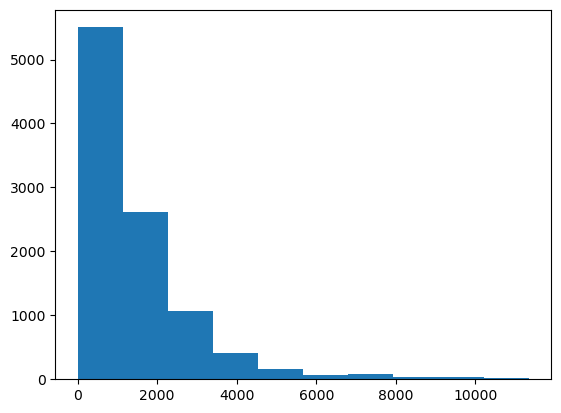

In [65]:
plt.hist(energy)

In [66]:
np.where((energy > 2142) & (energy < 2300))

(array([  50,   51,   52,   53,   54,   55,   76,   85,   87,   88,   89,
          90,   91,   92,   98,   99,  100,  101,  102,  103,  104,  105,
         106,  107,  108,  109,  111,  112,  115,  123,  573,  575,  578,
         579,  625,  749,  750,  751,  752,  753,  754,  755,  756,  757,
         758,  759,  760,  761,  762,  763,  764,  765,  766,  767,  768,
         769,  775,  776,  777,  778,  779,  780,  781,  782,  790,  792,
         793,  818,  819,  820,  821, 3548, 3549, 3593, 3594, 3595, 3596,
        3598, 3599, 3600, 3631, 3870, 3871, 4010, 4011, 4081, 4082, 4112,
        4113, 4151, 4152, 4204, 4205, 4235, 4236, 4237, 4238, 4239, 4240,
        4241, 4243, 4244, 4439, 4440, 4565, 4566, 4670, 4671, 4672, 4673,
        4732, 4733, 4921, 4922, 4923, 5045, 5046, 5047, 5048, 5049, 5050,
        5051, 5477, 5478, 5634, 5635, 5929, 5930, 5931, 5932, 5933, 5934,
        5935, 5936, 5937, 5938, 5939, 5944, 5948, 5949, 5950, 5951, 5966,
        5967, 5968, 6255, 6260, 6270, 

In [67]:
x.shape

torch.Size([1, 256, 256])

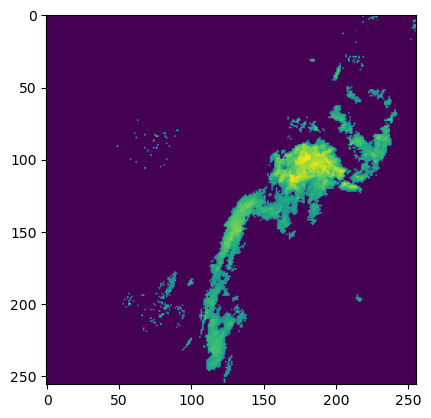

In [62]:
plt.imshow(training_dataset[9082][0][0][0].numpy())

In [52]:
torch.sum(training_dataset[1247][0][0][0])

tensor(1353.3411)

In [ ]:
torch.

In [68]:
np.quantile(energy, q=0.5)

939.1173400878906

In [71]:
x = training_dataset[0][0]

SyntaxError: invalid syntax (4115707581.py, line 1)

In [75]:
U.shape

torch.Size([8, 1, 65536])

In [69]:
[:]*4

SyntaxError: invalid syntax (643856293.py, line 1)

In [7]:
i

587

In [9]:
(x[0][0] == 255).any()

tensor(True)

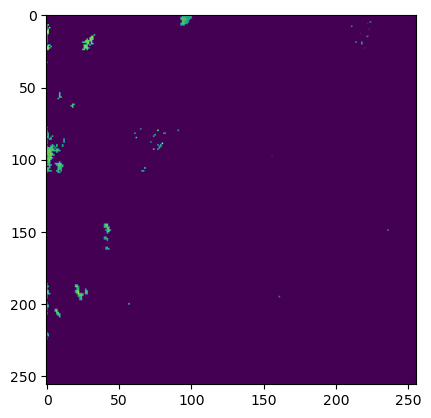

In [7]:
plt.imshow(x[0][0].numpy())

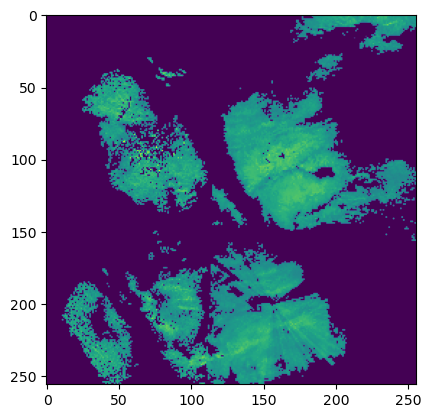

In [5]:
plt.imshow(a[0][0].numpy())

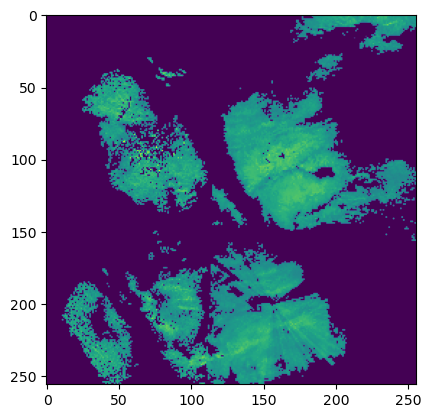

In [9]:
plt.imshow(training_dataset[0][0][0][0].numpy())

In [25]:
from torchvision.transforms.functional import crop

In [26]:
crop(a, top=550, left=50, height=256, width=256)

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

In [34]:
a = training_dataset[0][0]

In [37]:
a[..., 550:850,50:300].shape

torch.Size([8, 1, 300, 250])

(array([2.39733e+05, 0.00000e+00, 1.11000e+02, 1.52430e+04, 8.15700e+03,
        2.92000e+02, 1.70000e+01, 0.00000e+00, 0.00000e+00, 1.39945e+05]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

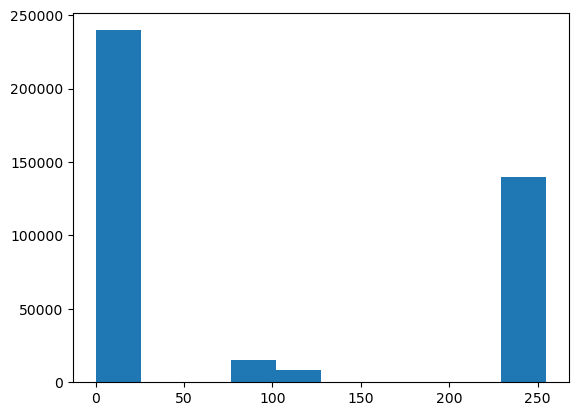

In [18]:
plt.hist(a.flatten())

In [4]:
training_sampler = InfiniteSampler(training_dataset, shuffle=True)

dataloader = DataLoader(
    training_dataset, sampler=training_sampler, batch_size=4, num_workers=12
)

train_dataiter = iter(dataloader)

In [5]:
from torch.nn.modules.pixelshuffle import PixelUnshuffle
from torch.nn.utils.parametrizations import spectral_norm

class ToyModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        
        # self.depth2space = PixelUnshuffle(downscale_factor=2)
        self.convlstm = ConvLSTM(1, 32, 3, 1)
        self.c1 = nn.Conv2d(32, 1, kernel_size=1, padding='same', padding_mode='replicate')
        
    def forward(self, x):
        # x = self.depth2space(x)
        _, x = self.convlstm(x)
        x = x[-1][-1]
        return self.c1(x.squeeze(1)).squeeze(1)
        
        
output_crop = CenterCrop((64, 64))

In [6]:
model = ToyModel(1, 2)

In [7]:
batch_X, batch_y = next(train_dataiter)

In [8]:
batch_X.shape

torch.Size([4, 8, 1, 128, 128])

In [9]:
z = model.convlstm(batch_X)

In [10]:
z[0].shape

torch.Size([4, 8, 32, 128, 128])

In [11]:
z[1][-1][-1].shape

torch.Size([4, 32, 128, 128])

In [12]:
out = model(batch_X)

In [13]:
out.shape

torch.Size([4, 128, 128])

In [14]:
loss = nn.MSELoss()

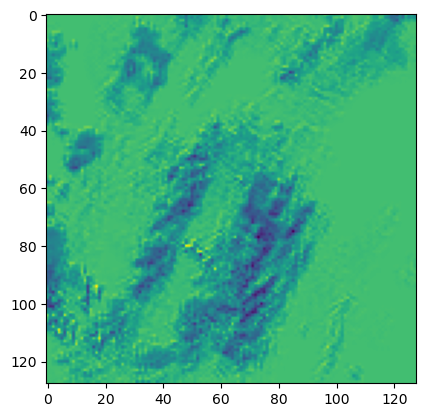

In [15]:
plt.imshow(out[0, ...].detach().cpu().numpy())

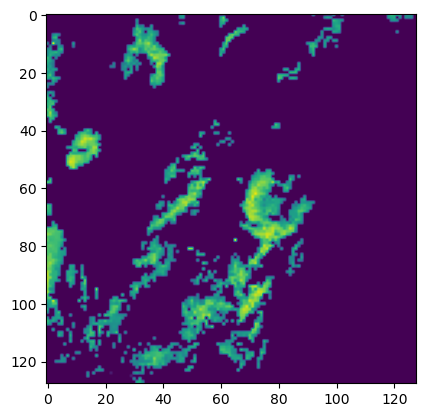

In [16]:
plt.imshow(batch_X[0, -1, 0])

In [17]:
l = loss(output_crop(out), output_crop(batch_y))

In [18]:
loss(output_crop(out[2]), output_crop(batch_y[2]))

tensor(3680.6543, grad_fn=<MseLossBackward0>)

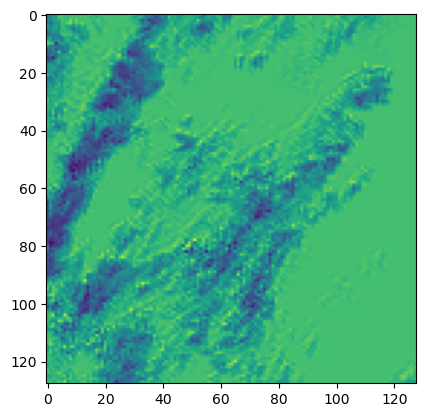

In [19]:
plt.imshow(out[2].detach().cpu().numpy())

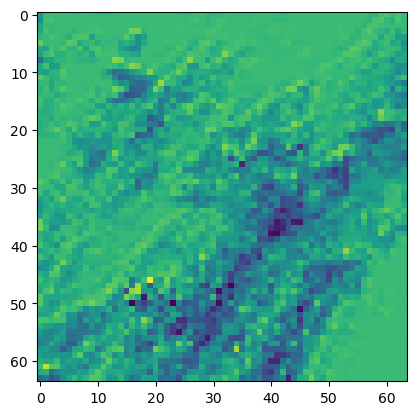

In [20]:
plt.imshow(output_crop(out[2]).detach().cpu().numpy())

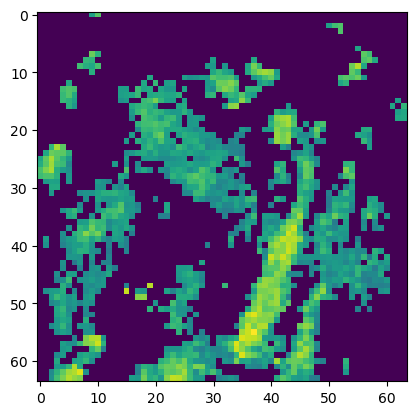

In [21]:
plt.imshow(output_crop(batch_y[2]))

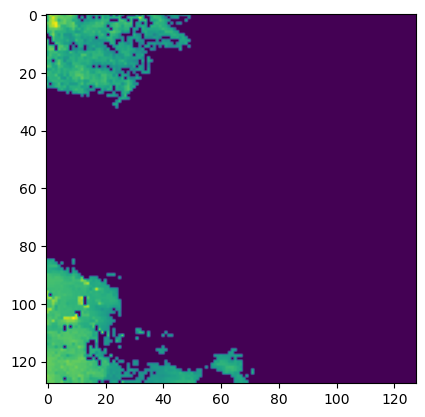

In [74]:
plt.imshow(batch_y[2])

In [38]:
l

tensor(3072.6362, grad_fn=<MseLossBackward0>)

In [82]:
l.backward()

In [ ]:
def main():
    

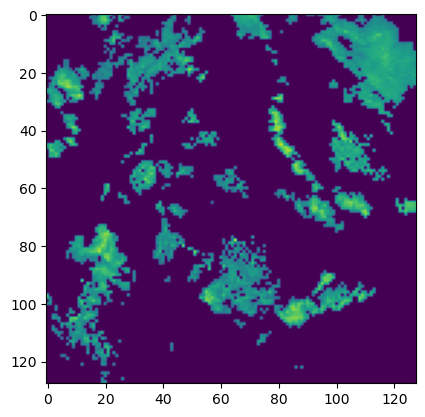

In [63]:
plt.imshow(batch_y[0])

In [29]:
h.shape

torch.Size([4, 1, 32, 128, 128])

In [34]:
len(c[0])

2

In [20]:
model.convlstm.input_dim

16

In [37]:
c[-1]

(tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 5.4767e-04,  5.0264e-04,  9.5402e-04,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 1.3246e-02,  6.3231e-03,  7.0259e-03,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [-1.5805e-03, -5.0491e-03, -1.9855e-03,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
 
          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],


In [ ]:
model.convlstm.input_dim